In [81]:
import os

import numpy as np
import pandas as pd
import re
import paramiko
from getpass import getpass
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [82]:
os.chdir("/home/stotoshka/Documents/ANGEL_dev")

In [ ]:
%%time
path_to_config = "TAP/data/converter_config.json"
command = f"python tools/generateConfigForConverter.py -i {os.path.join(os.getcwd(),'TAP/data/train/total_train_TAP.csv')} -o {os.path.join(os.getcwd(),'TAP/data/sdf')} -c PEPTIDE -t 10 {path_to_config}"
os.system(command)
print("Convertation")
convert_command = f"python tools/SeqToSDF.py {path_to_config}"
os.system(convert_command)

In [ ]:
%%time
path_to_config = "TAP/data/converter_config.json"
command = f"python tools/generateConfigForConverter.py -i {os.path.join(os.getcwd(),'TAP/data/validation/validation_TAP.csv')} -o {os.path.join(os.getcwd(),'TAP/data/sdf')} -c PEPTIDE -t 10 {path_to_config}"
os.system(command)
print("Convertation")
convert_command = f"python tools/SeqToSDF.py {path_to_config}"
os.system(convert_command)

In [ ]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
rm TAP/data/sdf/*.txt
cp TAP/data/sdf/total_train_TAP.sdf /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/TAP/sdf
cp TAP/data/sdf/validation_TAP.sdf /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/TAP/sdf

In [ ]:
command = f"python tools/generateConfigForTrain.py -l {6} -b total_TAP_6 -s sdf/total_train_TAP.sdf -a activity -p models/total_TAP_6 /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/TAP/total_TAP_6_tr.txt"
os.system(command)

In [ ]:
command = f"python tools/generateConfigForPrediction.py -m models/total_TAP_6.MSAR -s sdf/validation_TAP.sdf -a activity -p results /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/TAP/total_TAP_6_val.txt"
os.system(command)

In [ ]:
def checkTrain(path):
    flag = False
    header = "No	 Check	 Number	 IAP	 20-Fold	 Activity Type"
    try:
        with open(path, "r", encoding="cp1252") as log:
            for line in log:
                if header in line:
                    flag = True
    except:
        traceback.print_exc()
    finally:
        return flag


def checkValidation(path):
    try:
        f = False
        with open(path, "r", encoding="cp1252") as log:
            for line in log:
                if "are predicted" in line:
                    comps = line.strip().split(" ")
                    if int(comps[0]) == int(comps[2]):
                        f = True
                    else:
                        f = False
    except:
        traceback.print_exc()
    finally:
        return f

In [ ]:
%%time
client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
password = getpass()
client.connect('192.168.0.10', username='SmirnygaTotoshka', password=password)

tr_command = r"C:\Users\SmirnygaTotoshka\Desktop\OLMPASS\OLMPASSdoSAR.exe C:\Users\SmirnygaTotoshka\Desktop\diplom\ANGEL\TAP\total_TAP_6_tr.txt"
stdin, stdout, stderr = client.exec_command(tr_command)  # Non-blocking call
exit_status = stdout.channel.recv_exit_status()  # Blocking call
if exit_status == 0:
    if checkTrain(f"/run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/TAP/models/total_TAP_6.HST"):
        print("Train ended")
    else:
        print(f"Train ended with errors")
else:
    print("Error", exit_status)
client.close()

In [ ]:
%%time
client.connect('192.168.0.10', username='SmirnygaTotoshka', password=password)
val_command = r"C:\Users\SmirnygaTotoshka\Desktop\OLMPASS\OLMPASS2CSV.exe C:\Users\SmirnygaTotoshka\Desktop\diplom\ANGEL\TAP\total_TAP_6_val.txt"
stdin_val, stdout_val, stderr_val = client.exec_command(val_command)  # Non-blocking call
exit_status_val = stdout_val.channel.recv_exit_status()
if exit_status_val == 0:
    if checkValidation(f"/run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/TAP/results/validation_TAP-total_TAP_6.HST"):
        print("Validation ended")
    else:
        print(f"Validation ended with errors")
else:
    print("Error validation", exit_status_val)
client.close()

In [ ]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
cp /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/TAP/models/total* TAP/data/validation/models/
cp /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/TAP/results/validation* TAP/data/validation/results

In [ ]:
path = f"TAP/data/validation/models/total_TAP_6.HST"
header = "No	 Check	 Number	 IAP	 20-Fold	 Activity"
tbl = pd.DataFrame(columns=["model_name", "descriptor_level", "iap", "twentyCV", "activity", "num_subst"])
with open(path, "r", encoding='cp1252') as f:
    split_name = re.split("_", os.path.splitext(os.path.basename(path))[0])
    model_name = split_name[1]
    level = split_name[2]
    lines = f.readlines()
    flag = False
    for line in lines:
        if header in line:
            flag = True
            continue
        if line == "\n" and flag:
            break
        if flag:
            components = re.split("\t\\s+", line)
            num_subst = components[2]
            iap = components[3]
            twentyCV = components[4]
            activity = components[5].strip()
            row = pd.DataFrame.from_dict({"model_name": [model_name],
                                          "descriptor_level": [int(level)],
                                          "num_subst": [int(num_subst)],
                                          "iap": [float(iap.replace(",", "."))],
                                          "twentyCV": [float(twentyCV.replace(",", "."))],
                                          "activity": [int(activity)]})
            tbl = pd.concat([tbl, row], ignore_index=True)
    if not flag:
        print(f"total not any predictable activity")
tbl.to_excel("TAP/data/validation/internal.xlsx", index = False)

In [ ]:
internal_res = pd.read_excel("TAP/data/validation/internal.xlsx")
internal_res.head()

In [83]:
path = f"TAP/data/validation/results/validation_TAP-total_TAP_6.csv"
columns_to_drop = ["Substructure Descriptors", "New Descriptors", "Possible Activities at Pa>Pi"]
header = 0
result = pd.DataFrame(columns=["model", "auc_roc", "ap"])
i = 0
model_name = f"ANGEL"
tbl = pd.read_csv(path, sep=";", header=header,decimal=",")
tbl = tbl.drop(columns=columns_to_drop)
tbl = tbl.dropna()
tbl = tbl.rename(columns={tbl.columns[0]: "activity"})
auc_roc = metrics.roc_auc_score(tbl["activity"], tbl["1"])
ap = metrics.average_precision_score(tbl["activity"], tbl["1"])
result.loc[i] = [model_name, auc_roc, ap]
i += 1
result.head()

,model,auc_roc,ap
0,ANGEL,0.604798,0.369246


In [ ]:
with open("TAP/data/validation/for_competitors.txt","w") as compet:
    val = pd.read_csv("TAP/data/validation/validation_TAP.csv",sep = ";")
    for i in val.index:
        compet.write(val.loc[i,"PEPTIDE"] + "\n")

In [ ]:
%%bash
echo "Sparse"
python TAP/competitors/runTAPREG.py -t sparse /home/stotoshka/Documents/ANGEL_dev/TAP/data/validation/for_competitors.txt /home/stotoshka/Documents/ANGEL_dev/TAP/data/validation/TAPREG_sparse.xlsx
echo "Blosum"
python TAP/competitors/runTAPREG.py -t blosum /home/stotoshka/Documents/ANGEL_dev/TAP/data/validation/for_competitors.txt /home/stotoshka/Documents/ANGEL_dev/TAP/data/validation/TAPREG_blosum.xlsx

In [84]:
val = pd.read_csv("TAP/data/validation/validation_TAP.csv",sep = ";")
sparse = pd.read_excel("TAP/data/validation/TAPREG_sparse.xlsx")
sparse = pd.merge(sparse,val, left_on="SEQUENCE", right_on="PEPTIDE")
sparse.head()

,NAME,SEQUENCE,TAP AFFINITY IC50 (nM),PEPTIDE,median_IC50_rel,activity
0,23,ARWAAAIAKK,63.23,ARWAAAIAKK,320,0
1,49,RYWANATRSF,72.91,RYWANATRSF,1900,0
2,9,AEFSPDAPDAAAAY,100.02,AEFSPDAPDAAAAY,40,1
3,8,AEFSPDAAAAY,100.02,AEFSPDAAAAY,48,1
4,6,AEFSAAPDAAY,100.02,AEFSAAPDAAY,80,1


In [85]:
sparse["pred"] = np.where(sparse["TAP AFFINITY IC50 (nM)"] > 100, 0, 1)
sparse["pred"].value_counts()

0    60
1     2
Name: pred, dtype: int64

In [86]:
result.loc[1] = ["TAPREG_sparse", metrics.roc_auc_score(sparse["activity"],sparse["pred"]), metrics.average_precision_score(sparse["activity"],sparse["pred"])]
result.head()

,model,auc_roc,ap
0,ANGEL,0.604798,0.369246
1,TAPREG_sparse,0.477273,0.290323


In [87]:
val = pd.read_csv("TAP/data/validation/validation_TAP.csv",sep = ";")
blosum = pd.read_excel("TAP/data/validation/TAPREG_blosum.xlsx")
blosum = pd.merge(blosum,val, left_on="SEQUENCE", right_on="PEPTIDE")
blosum["pred"] = np.where(blosum["TAP AFFINITY IC50 (nM)"] > 100, 0, 1)
result.loc[2] = ["TAPREG_blosum", metrics.roc_auc_score(blosum["activity"],blosum["pred"]), metrics.average_precision_score(blosum["activity"],blosum["pred"])]
result.head()

,model,auc_roc,ap
0,ANGEL,0.604798,0.369246
1,TAPREG_sparse,0.477273,0.290323
2,TAPREG_blosum,0.477273,0.290323


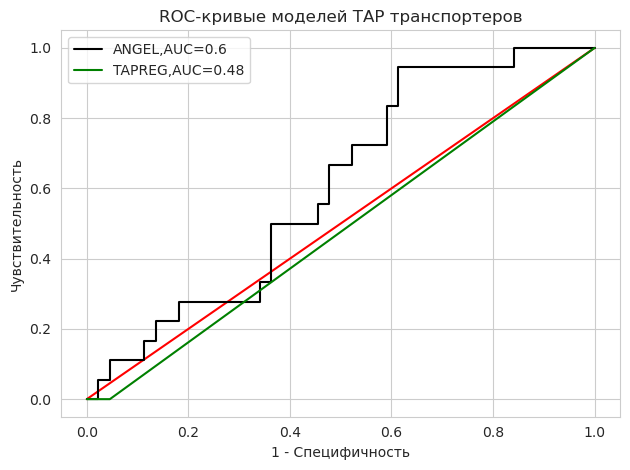

In [88]:
angel_fpr,angel_tpr,angel_tresholds = metrics.roc_curve(tbl["activity"], tbl["1"])
tapreg_fpr,tapreg_tpr,tapreg_tresholds = metrics.roc_curve(sparse["activity"],sparse["pred"])
angel_coords = pd.DataFrame({"fpr":angel_fpr,"tpr":angel_tpr,"thresholds":angel_tresholds})
tapreg_coords = pd.DataFrame({"fpr":tapreg_fpr,"tpr":tapreg_tpr,"thresholds":tapreg_tresholds})
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), color = "red")
plt.plot(angel_fpr, angel_tpr, color = "black", label = f"ANGEL,AUC={round(result.loc[0,'auc_roc'],2)}")
plt.plot(tapreg_fpr, tapreg_tpr,color = "green", label = f"TAPREG,AUC={round(result.loc[1,'auc_roc'],2)}")
plt.xlabel("1 - Специфичность")
plt.ylabel("Чувствительность")
plt.title("ROC-кривые моделей ТАР транспортеров")
plt.legend()
plt.tight_layout()
plt.savefig("TAP/data/validation/roc.png")

In [79]:
angel_coords["Gmean"] = np.sqrt(angel_coords["tpr"] * (1 - angel_coords["fpr"]))
angel_coords["J"] = angel_coords["tpr"] - angel_coords["fpr"]
optim_threshold_angel = angel_coords.loc[np.argmax(angel_coords["J"]),"thresholds"]
optim_threshold_angel

0.0261

In [80]:
tbl1 = tbl.copy(deep = True)
tbl1["pred"] = np.where(tbl1["1"] < optim_threshold_angel, 0, 1)
model_summary = pd.DataFrame(columns=["Sens","Spec","PPV","NPV","Precision",'Accuracy',"Balanced Accuracy", "F1", "MCC"])
tn, fp, fn, tp = metrics.confusion_matrix(tbl1["activity"],tbl1["pred"]).ravel()
model_summary.loc["ANGEL","Sens"] = tp / (tp + fn)
model_summary.loc["ANGEL","Spec"] = tn / (tn + fp)
model_summary.loc["ANGEL","PPV"] = tp / (tp + fp)
model_summary.loc["ANGEL","NPV"] = tn / (tn + fn)
model_summary.loc["ANGEL","Precision"] = metrics.precision_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["ANGEL","Accuracy"] = metrics.accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["ANGEL","Balanced Accuracy"] = metrics.balanced_accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["ANGEL","F1"] = metrics.f1_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["ANGEL","MCC"] = metrics.matthews_corrcoef(tbl1["activity"],tbl1["pred"])

tn, fp, fn, tp = metrics.confusion_matrix(sparse["activity"],sparse["pred"]).ravel()
model_summary.loc["TAPREG","Sens"] = tp / (tp + fn)
model_summary.loc["TAPREG","Spec"] = tn / (tn + fp)
model_summary.loc["TAPREG","PPV"] = tp / (tp + fp)
model_summary.loc["TAPREG","NPV"] = tn / (tn + fn)
model_summary.loc["TAPREG","Precision"] = metrics.precision_score(sparse["activity"],sparse["pred"])
model_summary.loc["TAPREG","Accuracy"] = metrics.accuracy_score(sparse["activity"],sparse["pred"])
model_summary.loc["TAPREG","Balanced Accuracy"] = metrics.balanced_accuracy_score(sparse["activity"],sparse["pred"])
model_summary.loc["TAPREG","F1"] = metrics.f1_score(sparse["activity"],sparse["pred"])
model_summary.loc["TAPREG","MCC"] = metrics.matthews_corrcoef(sparse["activity"],sparse["pred"])

model_summary.head()

,Sens,Spec,PPV,NPV,Precision,Accuracy,Balanced Accuracy,F1,MCC
ANGEL,0.944444,0.386364,0.386364,0.944444,0.386364,0.548387,0.665404,0.548387,0.330808
TAPREG,0.0,0.954545,0.0,0.7,0.0,0.677419,0.477273,0.0,-0.116775


In [ ]:
tp